#Создание отчетов AriaDNA.

In [2]:
# !pip install openpyxl==3.0.9 -qq
!pip install python-docx -qq

     |████████████████████████████████| 5.6 MB 5.2 MB/s 


##Качественный анализ

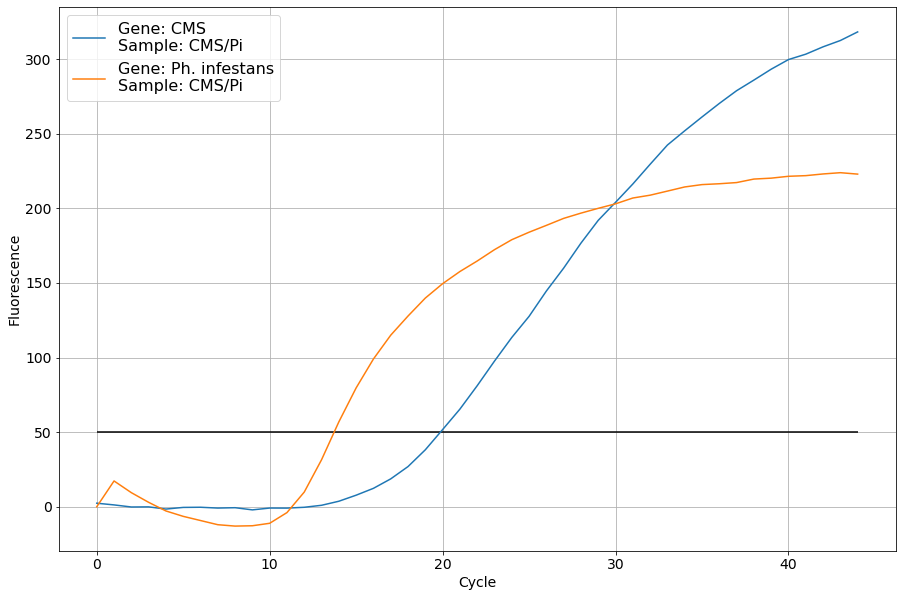

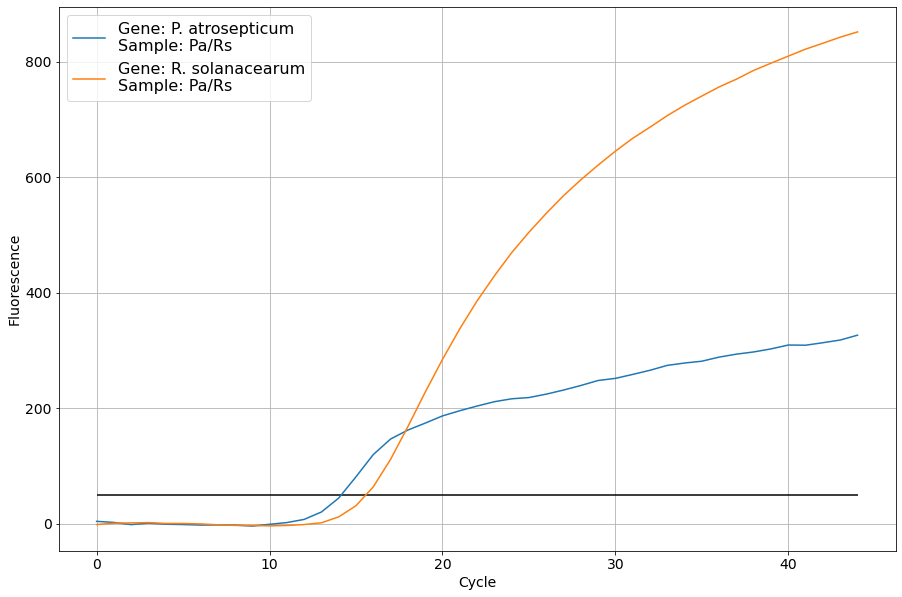

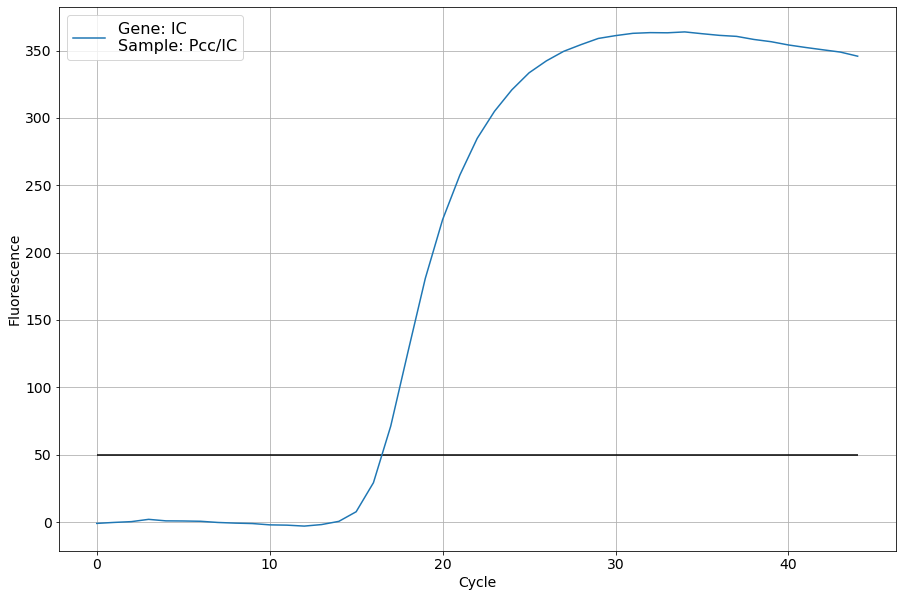

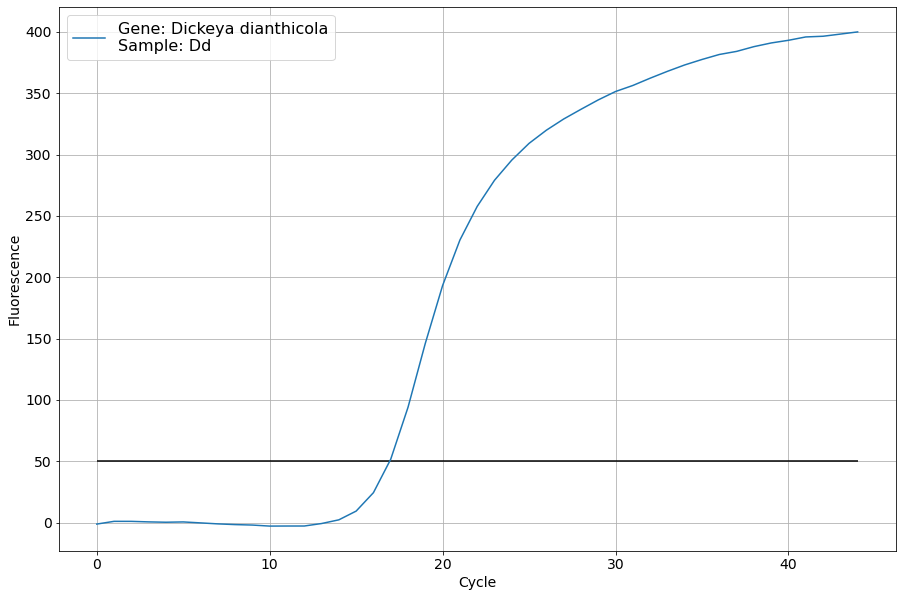

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import docx
import os
from datetime import datetime


def draw_curves(data, df):
    cells_to_draw = []
    legend_names = []
    curves_names = df.Gene_Sample.unique()
    for curve in curves_names:
        result = df.loc[(df.Gene_Sample == curve) & (df.ThresholdCycle != 0)]
        if result.shape[0] > 0:
            result_min = result[result.ThresholdCycle == 
                                result.ThresholdCycle.min()]               
            cells_to_draw.append(result_min.Key.values[0])
            legend_names.append('Gene: ' + result_min.Gene.values[0]
                                + '\n' + 'Sample: ' + result_min.Type.values[0])
        else:
            continue

    if cells_to_draw:
        data[cells_to_draw].plot(figsize=(15, 10), grid=True, fontsize=14)
        plt.legend(legend_names, loc='upper left', fontsize=16)
        plt.hlines(50, 0, 44)
        plt.xlabel(xlabel='Cycle', fontsize=14)
        plt.ylabel(ylabel='Fluorescence', fontsize=14)
        # pict = df.Gene.values[0].replace('.', '_')   # если картинки по генам
        pict = df.Type.values[0].replace('.', '_')   # если по образцам
        pict = pict.replace('/', '_')
        plt.savefig(pict + '_' + out_name)

for address, dirs, files in os.walk(os.getcwd()):
    for file in files:
        if file.endswith('.xlsx'):
            path_to_file = address + '/' + file

out_name = path_to_file.split('/')[-1].split('.')[0]

curves = pd.read_excel(path_to_file, sheet_name=2)
results = pd.read_excel(path_to_file, sheet_name=3)

n = curves.shape[1] // 2

if n == 30:
    n_rows = 5
    n_cols = 6
elif n == 48:
    n_rows = 6
    n_cols = 8
else:
    raise ValueError('Invalid matrix configuration!')

d_vals = ['Ch0_Cell' + str(i) for i 
          in range(n)] + ['Ch1_Cell'+ str(i) for i 
          in range(n)]
d_keys = [chr(i) + str(j) + '_1'for i 
            in range(65, 65 + n_rows) for j 
            in range(1, n_cols + 1)] + [chr(i) + str(j) + '_2'for i 
            in range(65, 65 + n_rows) for j 
            in range(1, n_cols + 1)]
cells = {k:v for k, v in zip(d_keys, d_vals)}

# чистка результатов
results = results[['Number', 'Channel', 'Gene', 'Type', 'ThresholdCycle']]
results = results[results.Gene != '---']
results['Channel'] = results.Channel.astype(str)
results.Type = results.Type.apply(lambda x: x[:-7])
list_of_cells = [cells[i + '_' + j] for i, j 
                 in zip(results['Number'].to_list(), 
                        results['Channel'].to_list())]
results['MaximumFluorescence'] = [curves[i][44] for i in list_of_cells]
results = results.round({'ThresholdCycle':2})
results.MaximumFluorescence = results.MaximumFluorescence.astype('int')
results.loc[(results.MaximumFluorescence < 200), 'MaximumFluorescence'] = 0
results.loc[(results.MaximumFluorescence == 0), 'ThresholdCycle'] = 0
results.to_excel('results_' + out_name + '.xlsx')

# картинки
results['Key'] = list_of_cells
results['Gene_Sample'] = results.Gene + ' ' + results.Type

# draw_curves(data=curves, df=results)  # на одном графике все кривые

# for gene in results.Gene.unique():      # по картинке на каждый ген
#     result_by_gene = results[results.Gene == gene]
#     draw_curves(data=curves, df=result_by_gene)

for sample in results.Type.unique():      # по картинке на каждый образец
    result_by_sample = results[results.Type == sample]
    draw_curves(data=curves, df=result_by_sample)

final_results = results.replace(0, np.nan)
final_results = final_results.pivot_table(columns=['Type', 'Gene'],
                                    values=['ThresholdCycle',
                                            'MaximumFluorescence'],
                                    aggfunc={'ThresholdCycle': [np.mean,
                                                                np.std],
                                             'MaximumFluorescence': np.mean})


# обработанные результаты
final_results = final_results.T
fin_res = final_results.reset_index()
cols = fin_res.columns
fin_res = fin_res.reindex(columns = [cols[0], cols[1], cols[3],
                                     cols[4], cols[2]])
fin_res = fin_res.round(2)
fin_res.to_excel('summary_' + out_name + '.xlsx')

# отчет
doc = docx.Document()
doc.add_heading(f'Отчет по анализу "{out_name}"', 0)
doc.add_paragraph('Анализ проведен на приборе AriaDNA.')
now = datetime.now()
doc.add_paragraph(f'Дата: {now.strftime("%d-%m-%Y")}')
doc.add_paragraph('Образцы и тест-системы:')
sample_dict = {}
for sample in results.Type.unique():  # какие образцы, тест-системы
    results_by_sample = results[results.Type == sample] 
    sample_dict[sample] = results_by_sample.Gene.unique()
for k in sample_dict.keys():
    doc.add_paragraph(k + ' -> ' + ', '.join(sample_dict[k])) 

doc.add_paragraph('Результаты:')
t = doc.add_table(fin_res.shape[0] + 1, fin_res.shape[1])
t.style = 'Table Grid'
t_head = ['Sample', 'Test-system',
          'Mean Ct', 'Std Ct', 'Mean Fluorescence']
for j in range(fin_res.shape[1]):  # заполнение заголовка
    t.cell(0,j).text = t_head[j]
for i in range(fin_res.shape[0]):  # заполнение значений таблицы
    for j in range(fin_res.shape[1]):
        t.cell(i+1,j).text = str(fin_res.values[i,j])
doc.add_paragraph()
doc.add_paragraph('Графики:')
for address, dirs, files in os.walk(os.getcwd()):
    for file in files:
        if file.endswith(out_name + '.png'):
            doc.add_picture(address + '/' + file, width=docx.shared.Cm(16))

doc.save('report_' + out_name + '.docx')

In [ ]:
!pip install python-docx -qq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import docx
import os
from datetime import datetime


     |████████████████████████████████| 5.6 MB 5.7 MB/s 


In [ ]:
df = pd.read_excel('/content/Хранение новых плазмид 2021.xlsx', sheet_name=1)
df.head()

,Дата,Прибор,Ct Pa_1,Fl Pa_1,Ct Rs_1,Fl Rs_1,Ct Pa_2,Fl Pa_2,Ct Rs_2,Fl Rs_2,Ct CMS_1,Fl CMS_1,Ct Pi_1,Fl Pi_1,Ct CMS_2,Fl CMS_2,Ct Pi_2,Fl Pi_2,Ct Pcc,Fl Pcc,Ct IC,Fl IC,Ct Ds_1,Fl Ds_1,Ct Ds_2,Fl Ds_2,Ct Dd_1,Fl Dd_1,Ct Dd_2,Fl Dd_2
0,2021-11-26,22,19.40,180.0,19.81,1200,18.12,720,20.66,2200,14.56,1300,17.37,560.0,18.03,1100,17.35,630,17.35,840.0,18.78,1400,21.09,340,NaN,NaN,21.47,1200,NaN,NaN
1,2021-11-26,22,18.09,390.0,19.55,1400,17.35,950,20.26,2600,14.78,1400,17.29,630.0,18.27,1300,17.31,790,18.06,380.0,18.28,1300,20.85,420,NaN,NaN,21.06,1200,NaN,NaN
2,2021-11-26,22,18.79,340.0,19.47,1500,17.48,1000,20.52,2600,14.65,1400,17.13,670.0,18.08,1400,17.16,790,17.63,840.0,19.48,1500,20.54,440,NaN,NaN,21.13,1300,NaN,NaN
3,2021-11-26,22,17.96,540.0,19.62,1400,17.32,1000,20.55,2400,14.45,1300,17.09,630.0,17.93,1300,17.24,750,17.71,670.0,18.07,1300,20.34,390,NaN,NaN,21.09,1100,37.84,190.0
4,2021-11-26,22,18.23,390.0,19.69,1200,17.48,850,20.36,2400,14.56,1300,17.34,590.0,17.80,1300,17.21,750,17.76,630.0,20.14,1200,20.45,380,NaN,NaN,21.10,1100,NaN,NaN


In [ ]:
df.columns

Index(['Дата', 'Прибор', 'Ct Pa_1', 'Fl Pa_1', 'Ct Rs_1', 'Fl Rs_1', 'Ct Pa_2',
       'Fl Pa_2', 'Ct Rs_2', 'Fl Rs_2', 'Ct CMS_1', 'Fl CMS_1', 'Ct Pi_1',
       'Fl Pi_1', 'Ct CMS_2', 'Fl CMS_2', 'Ct Pi_2', 'Fl Pi_2', 'Ct Pcc',
       'Fl Pcc', 'Ct IC', 'Fl IC', 'Ct Ds_1', 'Fl Ds_1', 'Ct Ds_2', 'Fl Ds_2',
       'Ct Dd_1', 'Fl Dd_1', 'Ct Dd_2', 'Fl Dd_2'],
      dtype='object')

In [ ]:
df[df['Дата'] == '2021-11-26'].groupby('Прибор').agg(['mean', np.ptp]).to_excel('DNA_26-11-2021.xlsx')